# Defining the Fully Convolutional Neural Network

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
class FCNN(nn.Module):
    
    def __init__(self):
        super(FCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=2)
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=120, out_channels=1, kernel_size=1, stride=1)
        
        
    def forward(self, data):
        x = F.relu(self.conv1(data))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.relu(self.conv3_drop(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x
        
network = FCNN()

# Loading the samples

In [3]:
POLLEN_DATA_CREATED = False
cur_dir = os.getcwd()
pollen_files = cur_dir + '/Data/PollenData/'
np_pollen_data = []     # single date will be [img,label]


if not POLLEN_DATA_CREATED:
    for folder in next(os.walk(pollen_files))[1]:
        if folder == 'Real':
            label = 1
        else:
            label = 0
        parent_path = os.path.join(pollen_files, folder)
        for file in os.listdir(parent_path):
            if '.png' in file:
                try:
                    path = os.path.join(parent_path, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    np_pollen_data.append([np.array(img), label])
                except Exception as e:
                    print(folder, file, str(e))

    np.random.shuffle(np_pollen_data)
    print("Data created.")


Data created.


In [4]:
# seperate the images and the labels into two lists:

images = []
labels = []

for i in range(len(np_pollen_data)):
    images.append(np_pollen_data[i][0][9:41,9:41]) #Achtung: Zu Testzwecken wurden hier die Bilder auf 32x32 gecroppt.
    labels.append(np_pollen_data[i][1])

print(len(images))

3246


In [ ]:
#Create Dataloader and augment it:

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(images),torch.Tensor(label)),batch_size=10)


In [5]:
# Split into train and validation set:

train_x = images[:int(len(images)*0.8)]
train_y = labels[:int(len(images)*0.8)]
valid_x = images[int(len(images)*0.8):]
valid_y = labels[int(len(images)*0.8):]

In [6]:
print(images[1].shape)

(32, 32)


In [7]:
# Create Dataloaders:

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_x),torch.Tensor(train_y)),batch_size=10)
validloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x),torch.Tensor(valid_y)),batch_size=100)

# Data Augmentation
and splitting the dataset into train and validation data. 

In [ ]:
#transform to tensor
pollen_data = [[torch.from_numpy(i[0]).view(-1,32,32)/255.0,i[1]] for i in np_pollen_data]

#create datasets
data_amount = len(pollen_data)
train_size = int(data_amount*0.8)
val_size = int(data_amount*0.1)

pollen_training_set = pollen_data[:train_size]
pollen_validation_set = pollen_data[train_size:val_size]
pollen_testing_set = pollen_data[val_size:]

# Train the Network

First we have a look at the performance of the untrained model on our validation set. 

In [8]:
ep = 100;

#Which optimizer and criterion should we choose? Perform best?
criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)


In [9]:
def validate(network, testloader):
    total = 0
    correct = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        validation_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(labels.size(0))
            loss = criterion(outputs,labels)
            validation_loss += loss.item()
            predicted = (outputs >= 0.9) # Predicted is a tensor of booleans 
            total += labels.size(0)
            predicted = predicted.view(predicted.size(0)) 
            #print(labels.size())
            #print((predicted == labels).sum().item())
            labels = labels == 1
            correct += (predicted == labels).sum().item()
            true_positive += (predicted & labels).sum().item()
            false_negative += (torch.logical_not(predicted) & labels).sum().item()
            false_positive += (predicted & torch.logical_not(labels)).sum().item()
            true_negative += (torch.logical_not(predicted) & torch.logical_not(labels)).sum().item()
            
        validation_loss = validation_loss / total 
        
        try: 
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0
        try:
            F1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            F1_score = 0
            
    # Kurzer Test, ob das stimmen kann:
    # print(true_positive)
    # print(false_negative)
    # print(false_positive)
    # print(true_negative)
    # print(total)
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    print('F1 Score of the network on the test images: %f' % F1_score)
    return validation_loss
    
validate(network, validloader)

Accuracy of the network on the test images: 50 %
F1 Score of the network on the test images: 0.001550


0.028124520322666696

In [10]:
# from pytorch blitz tutorial

def train(network, trainloader, ep, criterion, optimizer, print_interval):
    losses = [] # Mean of loss/image in every epoch of training 
    validation_losses = []
    validate(network, validloader)
    
    for epoch in range(ep):

        loss_stats = 0.0
        total = 0
        
        running_loss = 0.0
    
        for i, (inputs, lables) in enumerate(trainloader):
    
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(lables.shape)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(outputs.shape)
            loss = criterion(outputs, lables)
            loss.backward() #propagate the error back through the network
            optimizer.step() #adjust the weights of the network depending on the propagated error
    
            #that's it.
            total += lables.shape[0]
            
            #Some statistics:
            running_loss += loss.item()
            
            loss_stats += loss.item()
            
            if i % print_interval == print_interval - 1:    # print every x mini-batches (loss for one batch)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0
        
        losses.append(loss_stats / total)
        #Test the network using the validation set after every epoch of training.
        validation_losses.append(validate(network, validloader))
        
    print('Finished Training')
    return losses, validation_losses

train_losses, val_losses = train(network, trainloader, ep, criterion, optimizer, 32)

Accuracy of the network on the test images: 50 %
F1 Score of the network on the test images: 0.000000
[1,    32] loss: 0.257
[1,    64] loss: 0.226
[1,    96] loss: 0.186
[1,   128] loss: 0.181
[1,   160] loss: 0.140
[1,   192] loss: 0.144
[1,   224] loss: 0.099
[1,   256] loss: 0.153
Accuracy of the network on the test images: 76 %
F1 Score of the network on the test images: 0.698522
[2,    32] loss: 0.105
[2,    64] loss: 0.114
[2,    96] loss: 0.105
[2,   128] loss: 0.113
[2,   160] loss: 0.093
[2,   192] loss: 0.108
[2,   224] loss: 0.117
[2,   256] loss: 0.111
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.888281
[3,    32] loss: 0.092
[3,    64] loss: 0.087
[3,    96] loss: 0.116
[3,   128] loss: 0.125
[3,   160] loss: 0.096
[3,   192] loss: 0.105
[3,   224] loss: 0.092
[3,   256] loss: 0.092
Accuracy of the network on the test images: 85 %
F1 Score of the network on the test images: 0.842876
[4,    32] loss: 0.092
[4,    64] loss: 

[29,    32] loss: 0.061
[29,    64] loss: 0.060
[29,    96] loss: 0.069
[29,   128] loss: 0.074
[29,   160] loss: 0.068
[29,   192] loss: 0.070
[29,   224] loss: 0.060
[29,   256] loss: 0.060
Accuracy of the network on the test images: 86 %
F1 Score of the network on the test images: 0.842845
[30,    32] loss: 0.060
[30,    64] loss: 0.057
[30,    96] loss: 0.066
[30,   128] loss: 0.069
[30,   160] loss: 0.065
[30,   192] loss: 0.072
[30,   224] loss: 0.070
[30,   256] loss: 0.062
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.867666
[31,    32] loss: 0.057
[31,    64] loss: 0.058
[31,    96] loss: 0.057
[31,   128] loss: 0.078
[31,   160] loss: 0.056
[31,   192] loss: 0.067
[31,   224] loss: 0.072
[31,   256] loss: 0.077
Accuracy of the network on the test images: 87 %
F1 Score of the network on the test images: 0.853786
[32,    32] loss: 0.062
[32,    64] loss: 0.055
[32,    96] loss: 0.068
[32,   128] loss: 0.072
[32,   160] loss: 0.06

[57,    32] loss: 0.056
[57,    64] loss: 0.055
[57,    96] loss: 0.059
[57,   128] loss: 0.062
[57,   160] loss: 0.054
[57,   192] loss: 0.075
[57,   224] loss: 0.061
[57,   256] loss: 0.052
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.876337
[58,    32] loss: 0.054
[58,    64] loss: 0.055
[58,    96] loss: 0.048
[58,   128] loss: 0.061
[58,   160] loss: 0.053
[58,   192] loss: 0.063
[58,   224] loss: 0.059
[58,   256] loss: 0.067
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.876395
[59,    32] loss: 0.053
[59,    64] loss: 0.056
[59,    96] loss: 0.060
[59,   128] loss: 0.061
[59,   160] loss: 0.048
[59,   192] loss: 0.058
[59,   224] loss: 0.067
[59,   256] loss: 0.057
Accuracy of the network on the test images: 90 %
F1 Score of the network on the test images: 0.895659
[60,    32] loss: 0.055
[60,    64] loss: 0.060
[60,    96] loss: 0.060
[60,   128] loss: 0.063
[60,   160] loss: 0.05

[85,    32] loss: 0.052
[85,    64] loss: 0.051
[85,    96] loss: 0.058
[85,   128] loss: 0.056
[85,   160] loss: 0.047
[85,   192] loss: 0.056
[85,   224] loss: 0.065
[85,   256] loss: 0.060
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.872743
[86,    32] loss: 0.063
[86,    64] loss: 0.056
[86,    96] loss: 0.053
[86,   128] loss: 0.056
[86,   160] loss: 0.049
[86,   192] loss: 0.059
[86,   224] loss: 0.053
[86,   256] loss: 0.065
Accuracy of the network on the test images: 91 %
F1 Score of the network on the test images: 0.905394
[87,    32] loss: 0.058
[87,    64] loss: 0.052
[87,    96] loss: 0.054
[87,   128] loss: 0.061
[87,   160] loss: 0.047
[87,   192] loss: 0.056
[87,   224] loss: 0.064
[87,   256] loss: 0.059
Accuracy of the network on the test images: 88 %
F1 Score of the network on the test images: 0.875912
[88,    32] loss: 0.057
[88,    64] loss: 0.056
[88,    96] loss: 0.049
[88,   128] loss: 0.053
[88,   160] loss: 0.04

# Validation

The performance on the validation data after training:

In [ ]:
# validate(network, validloader) (Validation wird direkt mit dem Training gemacht. Nach jeder Epoche.)

# Plot Losses

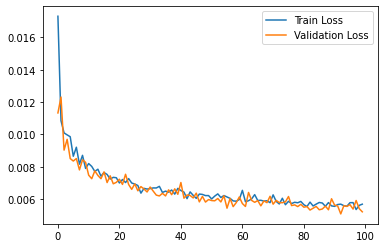

In [11]:
import matplotlib.pyplot as plt 

plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train Loss", "Validation Loss"])
plt.show()